Ces données ont été tirées du site data.gouv.fr. C’est le site de référence de l’open data en France.

Pour ce projet nous avons 4 fichiers différents.

carac.csv nous donne des caractéristiques sur les accidents                                                           
lieux.csv recense des données sur les lieux des accidents                                                             
veh.csv donne des informations sur les véhicules impliqués                                                           
vict.csv donne des informations sur les victimes




In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import imblearn


from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score


In [2]:
veh= pd.read_csv('/Users/rayane/Desktop/DonneeAccident/veh.csv',sep=';')
lieux= pd.read_csv('/Users/rayane/Desktop/DonneeAccident/lieux.csv',sep=';')
vict=pd.read_csv('/Users/rayane/Desktop/DonneeAccident/vict.csv',sep=';')
carac= pd.read_csv('/Users/rayane/Desktop/DonneeAccident/carac.csv',sep=';')

/Users/rayane/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vict.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh
0,201800000001,1.0,1,3,1,0.0,11.0,0.0,0.0,0.0,1928.0,B01
1,201800000001,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01
2,201800000002,1.0,1,1,1,0.0,11.0,0.0,0.0,0.0,1947.0,A01
3,201800000002,NaN,3,4,1,0.0,2.0,2.0,3.0,1.0,1959.0,A01
4,201800000003,1.0,1,3,1,5.0,21.0,0.0,0.0,0.0,1987.0,A01


In [141]:
veh.head()

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh
0,201800000001,0.0,7,0,0.0,2.0,3.0,1.0,B01
1,201800000001,0.0,7,0,0.0,2.0,2.0,15.0,A01
2,201800000002,0.0,7,0,0.0,1.0,0.0,1.0,A01
3,201800000003,0.0,33,0,1.0,2.0,1.0,1.0,A01
4,201800000003,0.0,7,0,0.0,2.0,8.0,15.0,B01


In [42]:
lieux.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,201800000001,3,41,NaN,C,2.0,2.0,NaN,NaN,0.0,1.0,3.0,NaN,NaN,1.0,0.0,1.0,0.0
1,201800000002,4,41,NaN,D,2.0,2.0,NaN,NaN,0.0,1.0,2.0,NaN,NaN,1.0,0.0,1.0,0.0
2,201800000003,3,39,NaN,D,2.0,2.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0
3,201800000004,3,39,NaN,NaN,2.0,2.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0
4,201800000005,4,NaN,NaN,NaN,1.0,1.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0


In [43]:
carac.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep
0,201800000001,18,1,24,1505,1,1,4,1.0,1.0,5,route des Ansereuilles,M,5055737.0,294992.0,590
1,201800000002,18,2,12,1015,1,2,7,7.0,7.0,11,Place du gйnйral de Gaul,M,5052936.0,293151.0,590
2,201800000003,18,3,4,1135,1,2,3,1.0,7.0,477,Rue nationale,M,5051243.0,291714.0,590
3,201800000004,18,5,5,1735,1,2,1,7.0,3.0,52,30 rue Jules Guesde,M,5051974.0,289123.0,590
4,201800000005,18,6,26,1605,1,2,1,1.0,3.0,477,72 rue Victor Hugo,M,5051607.0,290605.0,590


Concrètement, pour chaque victime, la gravité de l’accident est donnée sur une échelle de 1 à 4 :

1 : Indemne
2 : Tué
3 : Hospitalisé
4 : Blessé léger

Le but de ce projet est donc de prédire la catégorie de la gravité de l'accident.                                     
C'est un problème de classification supervisée multiclasses.

# Préparation des données 

In [93]:
victime = vict.merge(veh,on=['Num_Acc','num_veh'])

In [94]:
accident = lieux.merge(carac,on='Num_Acc')

In [95]:
victime=vict.merge(accident,on='Num_Acc')

#### Analyse exploratoire des données
L'analyse exploratoire va nous permettre d'en savoir plus sur le type de variables auxquelles nous avons à faire, sur leurs distributions et sur les liens que les variables ont entre elles.
On remarque en particulier que le jeu de données est déséquilibré en effet nos labels sont pas répartis équitablement au sein du jeu de données, ce qui peut biaiser notre modèle en faveur des labels les plus représentés.
Il faudra surement utiliser des techniques de ré-échantillonnage pour rééquilibrer le jeu de donnée. 

In [293]:
prof = ProfileReport(victime)
prof.to_file(output_file='rapport.html')

/Users/rayane/opt/anaconda3/lib/python3.7/site-packages/pandas_profiling/visualisation/plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


In [7]:
victime['grav'].value_counts() # Jeu de donnée fortement déséquilibré, ré-échantillonnage à faire ! 

1    53268
4    49367
3    21945
2     3371
Name: grav, dtype: int64

### Gestion des valeurs manquantes 
L'analyse exploratoires nous a fournit une information clé, il y a des valeurs manquantes. 
Nous allons voir quelle stratégie adopter face à ces valeurs manquantes. 

In [8]:
victime.shape[0]*victime.shape[1]-np.count_nonzero(victime) # nombre de valeurs manquantes 

695072

In [96]:
MissingValues=victime.isna().sum()
MissingValues.sort_values(ascending=False) 
# We can't remove all the ligns containing one missing value because for the variable v1 , 
# it represent almost 100%, so we decide to remove all the variables with more than 20% missing values in all the dataset 


v1         127598
v2         122041
lartpc      99657
larrout     98705
locp        53056
actp        53054
etatp       53053
voie        45013
pr1         33508
pr          32899
place       10726
lat          4107
long         4107
secu         4054
adr          1272
vosp         1209
nbv          1163
situ         1134
infra        1075
env1         1059
surf         1024
prof         1005
plan          971
circ          924
trajet        114
gps           103
an_nais        30
atm             9
col             8
sexe            0
grav            0
catu            0
dep             0
num_veh         0
catr            0
an              0
mois            0
jour            0
hrmn            0
lum             0
agg             0
int             0
com             0
Num_Acc         0
dtype: int64

In [10]:
ProportionMissingValues=MissingValues*100/127951

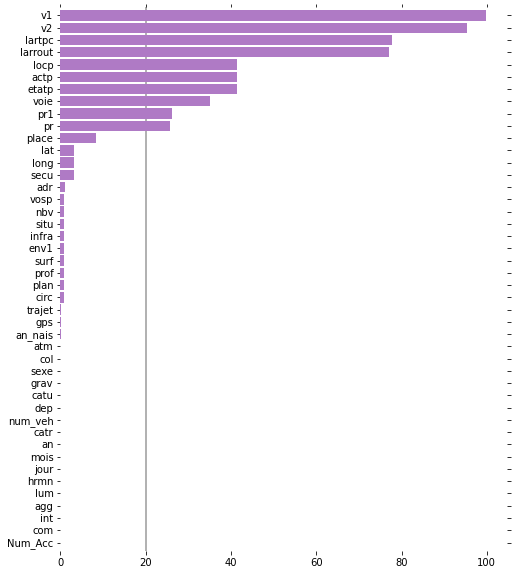

In [11]:
ax = ProportionMissingValues.sort_values().plot(kind='barh', 
                     figsize=(8, 10), 
                     color='#AF7AC5',
                     zorder=2,
                     width=0.85)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", 
               which="both", 
               bottom="off", 
               top="off", 
               labelbottom="on", 
               left="off", 
               right="off", 
               labelleft="on")

ax.axvline(x=20, alpha=0.4, color='black', zorder=1)


On a placé une ligne verticale qui correspond au 20 % choisie, donc on supprime les variables v1,v2,lartpc,larrout,locp,actp,etatp,voie,pr1,pr. 


In [97]:
features=['v1','v2','lartpc',
       'larrout','locp','etatp',
       'actp','voie','pr1',
       'pr',]
victime=victime.drop(columns=features)


In [98]:
victime.shape ## Nouvelle shape de victime

(127951, 34)

In [14]:
victime.isna().sum().sum() ## Nombre de valeurs manquantes donc on supprime les lignes qui contiennent ces valeurs manquantes


34094

In [99]:
victime=victime.dropna()

In [100]:
victime.shape ## Finalement on a 110394 et 34 colonnes, il n'y a plus de valeurs manquantes ! 

(110394, 34)

## Analyse des corrélations entres les variables numériques
On cherche ici à voir si les variables sont fortement corrélées, si 2 variables sont fortement corrélées alors cela indique qu'elles contiennent la même information et il faudra donc en supprimer une.

/Users/rayane/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


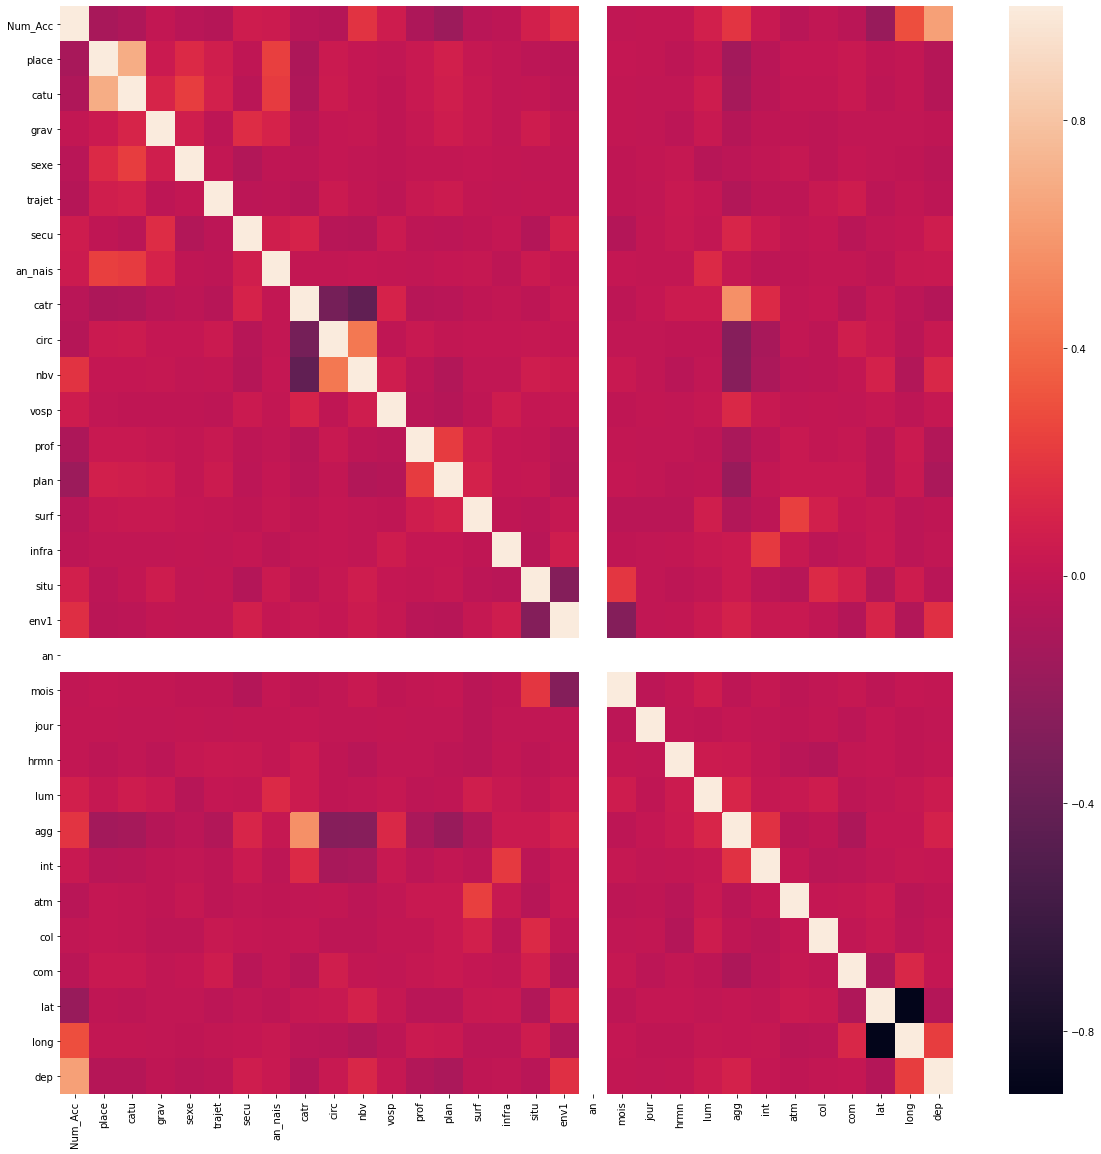

In [17]:
import seaborn as sn
corrMatrix = victime.corr()
plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix)
plt.show()

On peut tirer beaucoup d'informations de cette matrice de corrélation. 
La première est la variable "an", elle ne se comporte pas comme les autres en effet on remarque que "an" n'est pas une variable aléatoire mais une constante, en effet elle est égale à 18 pour toutes les lignes donc elle n'apporte aucune information on peut donc la supprimer.
La seconde est qu'on observe de fortes corrélations pour les variables lat et long, en effet on comprend très bien qu'elles ont un lien entre elles car elles nous donnent des informations sur la position géographique(latitude et longitude), il va falloir les regrouper en une seule variable. 


In [101]:
victime=victime.drop(columns='adr')
victime=victime.drop(columns='an')

## Encodage des variables non numériques

 On remarque qu'on a des variable de type object (catégorique) comme num_veh,gps 
 qui nécessite un encodage pour être utilisé par les algorithmes de machine learning.

In [19]:
victime.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110394 entries, 0 to 127950
Data columns (total 32 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  110394 non-null  int64  
 1   place    110394 non-null  float64
 2   catu     110394 non-null  int64  
 3   grav     110394 non-null  int64  
 4   sexe     110394 non-null  int64  
 5   trajet   110394 non-null  float64
 6   secu     110394 non-null  float64
 7   an_nais  110394 non-null  float64
 8   num_veh  110394 non-null  object 
 9   catr     110394 non-null  int64  
 10  circ     110394 non-null  float64
 11  nbv      110394 non-null  float64
 12  vosp     110394 non-null  float64
 13  prof     110394 non-null  float64
 14  plan     110394 non-null  float64
 15  surf     110394 non-null  float64
 16  infra    110394 non-null  float64
 17  situ     110394 non-null  float64
 18  env1     110394 non-null  float64
 19  mois     110394 non-null  int64  
 20  jour     110394 non-null  

In [20]:
victime['gps'].unique()

array(['M', 'A', 'G', 'R', 'Y'], dtype=object)

La variable hrmn qui correspond aux heures des accidents nécessite un encodage particulier, il faut discrétiser cette variable en assignant un code pour chaque heure 
exemple 0 pour l'intervalle [00:00 ; 00:59] etc...

In [102]:
hrmn=pd.cut(victime['hrmn'],24,labels=[str(i) for i in range(0,24)])

In [103]:
pd.cut(victime['hrmn'],24,labels=[str(i) for i in range(0,24)])

0         15
1         15
2         10
4         11
5         11
          ..
127945    21
127947    19
127948    19
127949    14
127950    14
Name: hrmn, Length: 110394, dtype: category
Categories (24, object): [0 < 1 < 2 < 3 ... 20 < 21 < 22 < 23]

In [104]:
victime['hrmn']=hrmn.values

In [105]:
victime['hrmn']=victime['hrmn'].astype(int)

Pour gérer les données gps(latiture et longitude) qui sont corrélés entre elles, il faut premiérement les regrouper en une seule variable. 
Ensuite pour obtenir une variable catégorique, on réalise un clustering afin de classer les localisations selon leurs proximités en leur attribuant une catégorie. 

In [106]:
# On extrait du tableau la latitude et la longitude

X_lat = victime['lat']
X_long = victime['long']

# On définit tous nos points à classifier

X_cluster = np.array((list(zip(X_lat, X_long))))


In [26]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_cluster)
    distortions.append(kmeanModel.inertia_)

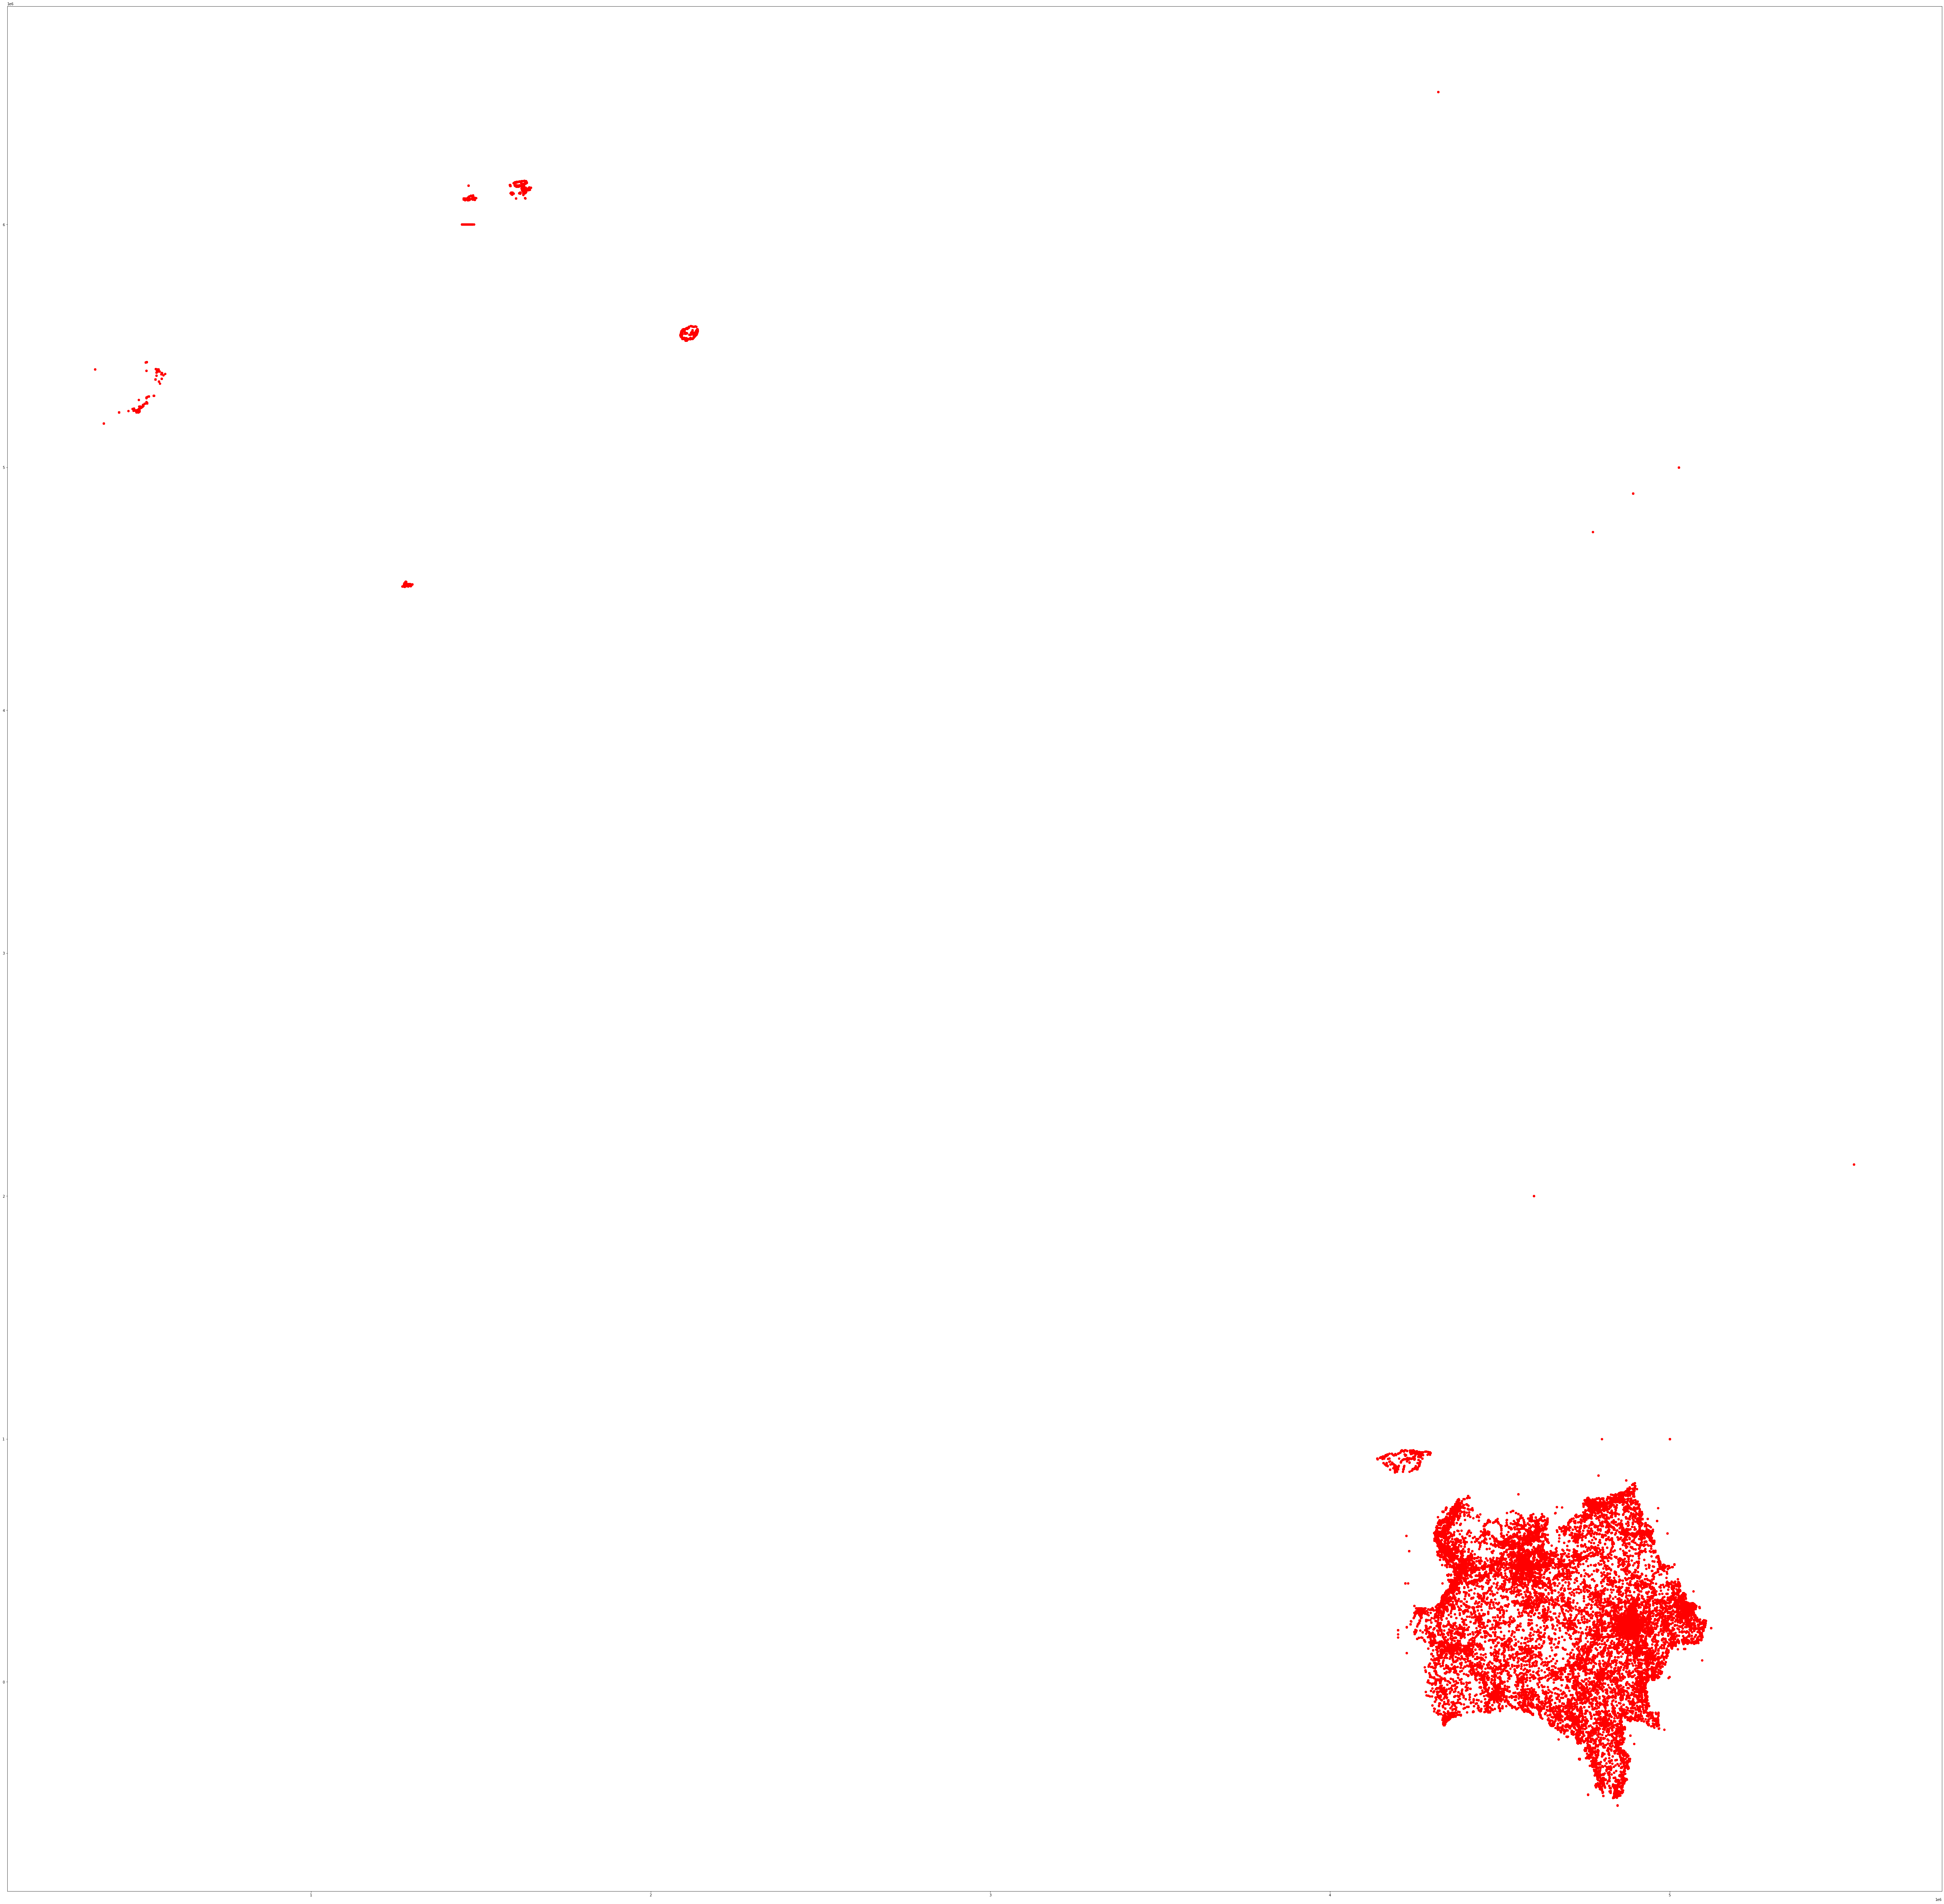

In [27]:
plt.figure(figsize=[100,100])
plt.scatter(X_lat,X_long ,c = 'red')  

Visuellement on peut avoir 6-7 groupes (cluster) donc intuitivement on choisit 7 comme paramétre pour le k-means

In [107]:
# Kmeans nous donne pour chaque point la catégorie associée

clustering = KMeans(n_clusters=7, random_state=0)
clustering.fit(X_cluster)

KMeans(n_clusters=7, random_state=0)

In [108]:
victime['geo']=clustering.labels_

In [109]:
victime['geo'].value_counts()

6    45270
0    18994
5    16453
3    12805
2    12785
1     2480
4     1607
Name: geo, dtype: int64

In [110]:
victime=victime.drop(columns=['lat','long'])

In [32]:
victime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110394 entries, 0 to 127950
Data columns (total 31 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  110394 non-null  int64  
 1   place    110394 non-null  float64
 2   catu     110394 non-null  int64  
 3   grav     110394 non-null  int64  
 4   sexe     110394 non-null  int64  
 5   trajet   110394 non-null  float64
 6   secu     110394 non-null  float64
 7   an_nais  110394 non-null  float64
 8   num_veh  110394 non-null  object 
 9   catr     110394 non-null  int64  
 10  circ     110394 non-null  float64
 11  nbv      110394 non-null  float64
 12  vosp     110394 non-null  float64
 13  prof     110394 non-null  float64
 14  plan     110394 non-null  float64
 15  surf     110394 non-null  float64
 16  infra    110394 non-null  float64
 17  situ     110394 non-null  float64
 18  env1     110394 non-null  float64
 19  mois     110394 non-null  int64  
 20  jour     110394 non-null  

In [111]:
X=pd.get_dummies(victime, columns=['num_veh','gps'])

In [112]:
X=X.dropna()
X=X.drop(columns='Num_Acc')

In [113]:
y = X['grav']
X=X.drop(columns='grav')

In [114]:
y.shape , X.shape

((110394,), (110394, 57))

Une fois que l'on a prétraité notre jeu de donnée, on peut dès à présent commencer l'étape la plus intéressante selon moi : la modélisation. 

C'est parti les amis  ! 


On commence doucement par établir un premier modèle très simple qui va nous servir de baseline et qu'on va essayer d'améliorer au fur et à mesure.  


## Modélisation  


On commence par séparer notre jeux de données en 3, un jeu d'entrainement, un jeu de validation et un jeu de test. 
On fait attention à utiliser le paramètre stratify qui nous assure une répartition des classes égales dans les 3 datasets. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

In [38]:
y_train.value_counts()/len(y_train)

1    0.452352
4    0.365119
3    0.157996
2    0.024533
Name: grav, dtype: float64

In [39]:
y_val.value_counts()/len(y_val)

1    0.452330
4    0.365143
3    0.158023
2    0.024503
Name: grav, dtype: float64

In [40]:
y_test.value_counts()/len(y_test)

1    0.452330
4    0.365143
3    0.158023
2    0.024503
Name: grav, dtype: float64

On remarque une répartition similaire dans les 3 jeux de données (validation,test,train) donc la stratification a bien fonctionné.

# Arbre de décision 
Commençons par établir un premier modèle tout simple: un arbre de décision.

In [169]:
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
## stratify pour conserver les proportions de classes dans le jeu d'entrainement et le jeu de test 

dtree_model = DecisionTreeClassifier(criterion='gini',max_depth=8,random_state=903).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_val) 
print('Results on the val set:')
print(classification_report(y_val, dtree_predictions))

Results on the val set:
              precision    recall  f1-score   support

           1       0.65      0.83      0.73      9987
           2       0.12      0.00      0.00       541
           3       0.49      0.38      0.43      3489
           4       0.60      0.49      0.54      8062

    accuracy                           0.62     22079
   macro avg       0.47      0.43      0.43     22079
weighted avg       0.59      0.62      0.60     22079



In [171]:

print("Validation Accuracy ",cross_val_score(dtree_model, X_val, y_val, cv=5).mean())
print("Ecart-Type",cross_val_score(dtree_model, X_val, y_val, cv=5).std())


Validation Accuracy  0.6068662600324979
Ecart-Type 0.0022810481529360626


## Méthodes ensemblistes 
#### 1) Adaboost

In [53]:
from sklearn.ensemble import AdaBoostClassifier 
# On construit le modèle :

Ada = AdaBoostClassifier(n_estimators=200)

# L'entraînement commence :

Ada.fit(X_train, y_train)

# On a maintenant les prédictions pour la base de test

predictions = Ada.predict(X_val)

print('Results on the test set:')
print(classification_report(y_val, predictions))

Results on the test set:
              precision    recall  f1-score   support

           1       0.63      0.82      0.71      9987
           2       0.20      0.03      0.05       541
           3       0.50      0.33      0.39      3489
           4       0.59      0.49      0.54      8062

    accuracy                           0.60     22079
   macro avg       0.48      0.42      0.43     22079
weighted avg       0.59      0.60      0.58     22079



In [54]:
val_score=cross_val_score(Ada, X_val, y_val, cv=5)
y_pred=Ada.predict(X_test)
print("Test Accuracy",accuracy_score(y_test, y_pred))
print("Validation Accuracy ",val_score.mean())
print("Ecart-Type",val_score.std())

Test Accuracy 0.6055074958104987
Validation Accuracy  0.5979437072233985
Ecart-Type 0.004268110621853917


Globalement au niveau de l'accuracy,du recall et du f1-score on note pas d'amélioration, un simple arbre de décision est meilleur. 
On sort maintenant l'artillerie lourde : Le Ramdom Forest 

#### 2) Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
## stratify pour conserver les proportions de classes dans le jeu d'entrainement et le jeu de test 
# On construit le modèle :

RF = RandomForestClassifier(random_state=930)

# L'entraînement commence :

RF.fit(X_train, y_train)

# On a maintenant les prédictions pour la base de test

RF_predictions = RF.predict(X_val)

print('Results on the test set:')
print(classification_report(y_val, predictions))

Results on the test set:
              precision    recall  f1-score   support

           1       0.63      0.82      0.71      9987
           2       0.20      0.03      0.05       541
           3       0.50      0.33      0.39      3489
           4       0.59      0.49      0.54      8062

    accuracy                           0.60     22079
   macro avg       0.48      0.42      0.43     22079
weighted avg       0.59      0.60      0.58     22079



In [75]:
score=cross_val_score(RF, X_val, y_val, cv=5)
print("Accuracy Moyenne",score.mean())
print("Accuracy Ecart-Type",score.std())

Accuracy Moyenne 0.6241225565020435
Accuracy Ecart-Type 0.002061385824919893


On s'améliore petit à petit, sans avoir paramétrer notre classifieur random forest on est dèjà au dessus des deux autres modèles. 
On va voir comment optimiser les hyperparamètres avec l'outils gridsearch. 
Il suffit de faire un dictionnaire avec les paramètres voulus et ce super outil magique va nous renvoyer les paramètres qui ont donner les meilleurs résultats ! 


In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer

param_grid = [
{'n_estimators': [100,200,300,500], 
 'max_depth': [10,20,30,50] }
]

RF_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
RF_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [30], 'n_estimators': [100, 200, 300]}])

In [66]:
RF_grid.best_params_

{'max_depth': 30, 'n_estimators': 300}

On lance un nouvel entrainement avec cette fois les paramètres donnés par gridsearch et normalement si tout va bien, on devrait avoir une amélioration.  

In [76]:
RF = RandomForestClassifier(n_estimators=300,max_depth=30,random_state=930)

# L'entraînement commence :

RF.fit(X_train, y_train)

# On a maintenant les prédictions pour la base de test

RF_predictions = RF.predict(X_val)

In [77]:
score=cross_val_score(RF, X_val, y_val, cv=5)
print("Accuracy Moyenne",score.mean())
print("Accuracy Ecart-Type",score.std())

Accuracy Moyenne 0.6277911373446912
Accuracy Ecart-Type 0.003536348567610534


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

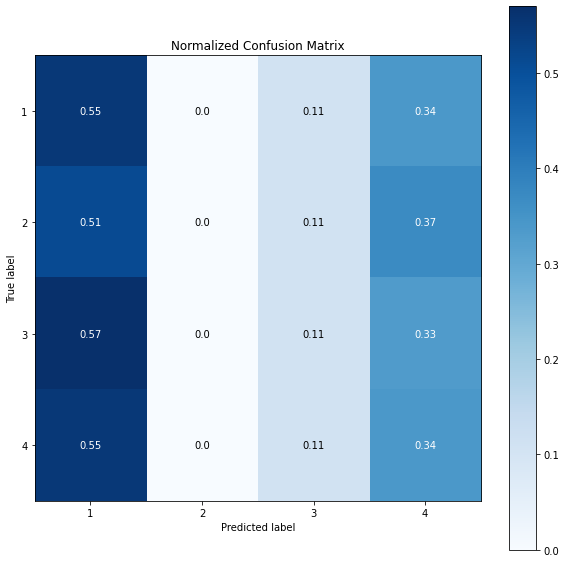

In [454]:
RF_predictions = RF.predict(X_val)
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, RF_predictions,normalize=True,figsize=(10,10))

On remarque à travers cette matrice de confusion que le modèle est "paresseux" il ne prédit jamais la classe 2 c'est dû au déséquilibre des classes. 

#### 3) XGBOOST

In [78]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV #Perforing grid search

In [86]:
from xgboost.sklearn import XGBClassifier

# On construit le modèle :

XGB = XGBClassifier(200, max_depth=20)

# L'entraînement commence :

XGB.fit(X_train, y_train)

# On a maintenant les prédictions pour la base de test

xgb_predictions = XGB.predict(X_val)

print('Results on the test set:')
print(classification_report(y_val, predictions))


[19:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { ramdom_state } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results on the test set:
              precision    recall  f1-score   support

           1       0.63      0.82      0.71      9987
           2       0.20      0.03      0.05       541
           3       0.50      0.33      0.39      3489
           4       0.59      0.49      0.54      8062

    accuracy                           0.60     22079
   macro avg       0.48      0.42      0.43     22079
weighted avg       0.59      0.60      0.58     22079



In [84]:
score=cross_val_score(XGB, X_val, y_val, cv=5)
print("Accuracy Moyenne",score.mean())
print("Accuracy Ecart-Type",score.std())

Accuracy Moyenne 0.6171022288968766
Accuracy Ecart-Type 0.004778353118401007


## Choix du modèle
Sur les jeux de validation le modèle qui a été le plus performant est le modèle random forest qu'on a optimisé donc c'est celui là que l'on va garder. 
On va évaluer maintenant les performances de notre modèle retenu sur le jeu de test qui je le rappelle est un jeu de donnée frais que le modèle n'as encore jamais utilisé. 

In [172]:
y_pred=RF.predict(X_test)
print("Test Accuracy",accuracy_score(y_test, y_pred))


Test Accuracy 0.6435526971330223


Prise de recul sur nos résultat.


On atteint environ 65% de bonne prédictions, ce qui reste assez décevant. 

Cependant j'aurais pu aller plus loin en essayant de résoudre le problème du déséquilibre des données car notre modèle ne prend pas en compte la classe sous représenté.

On pourrait utiliser un super classifieur qui fait voter des classifieurs et qui serait surement plus robuste.
On pourrait aller plus loin dans l'optimisation des hyperparamétres.
On peut aussi se dire que prédire un accident mortel comporte quand même beaucoup d'aléas quand on sait que dans certains accident très violent des personnes sortent indemnes et d'autre non...
